In [7]:
import pandas as pd
from pathlib import Path

In [132]:
# DATASET = "zappos"
DATASET = "strange_fruit"
# NOISE_MODEL = "CKL"
NOISE_MODEL = "TSTE"
# NOISE_MODEL = "STE"
d = 2

DATA_DIR = Path(f"cluster-data3-reversed-score//")

dfs = [pd.read_parquet(f) for f in DATA_DIR.glob("*.parquet")]
print(len(dfs))
dfs = [
    df
    for df in dfs
    if (
        df.loc[0, "noise_model"] == NOISE_MODEL
        and df.loc[0, "d"] == d
        and df.loc[0, "dataset"] == DATASET
    )
]
print(len(dfs))
df = pd.concat(dfs)
df.acc.max()
df.columns

40
14


Index(['acc', 'embedding_max', 'pf_time', 'n', 'd', 'R', 'dataset',
       'max_queries', 'n_partial_fit', 'n_search', 'n_test', 'noise_model',
       'prefix', 'queries_per_search', 'random_state', 'write', 'sampling',
       'optimizer', 'optimizer__lr', 'optimizer__momentum', 'module__alpha',
       'num_ans', 'model_updates', 'process_answers_calls'],
      dtype='object')

In [138]:
df.n.unique()

array([200])

In [133]:
df.columns

Index(['acc', 'embedding_max', 'pf_time', 'n', 'd', 'R', 'dataset',
       'max_queries', 'n_partial_fit', 'n_search', 'n_test', 'noise_model',
       'prefix', 'queries_per_search', 'random_state', 'write', 'sampling',
       'optimizer', 'optimizer__lr', 'optimizer__momentum', 'module__alpha',
       'num_ans', 'model_updates', 'process_answers_calls'],
      dtype='object')

In [141]:
np.sort(df.n_search.unique())

array([    10,     20,     50,    100,    200,    500,   1000,   2000,
         5000,  10000,  20000,  50000, 100000, 200000])

In [134]:
import numpy as np
df["log_n_search"] = np.log10(df.n_search)

In [135]:
df["queries_searched_per_user"] = df["n_search"] / df["queries_per_search"]

In [170]:
import altair as alt

show = df.copy()

mul = 2
n_search = [mul * 10 ** i for i in range(0, 10)]
n_search = [10] + n_search
print(n_search)
# n_search = show.n_search.unique()

print(show.n_search.unique())
show = show[show.n_search.isin(n_search)]
print(show.n_search.unique())
show = show[show.num_ans <= 10_000]
show["accuracy"] = show["acc"] * 100

alt.Chart(show, title="Search efficacy").mark_line().encode(
    x=alt.X("num_ans", scale=alt.Scale(zero=False), axis=alt.Axis(title='Answers received')),
    y=alt.Y("accuracy", scale=alt.Scale(zero=False), axis=alt.Axis(title='Test accuracy (%)')),
    color=alt.Color(
        "queries_searched_per_user:N",
        scale=alt.Scale(scheme='viridis', type="log"),
        title="Queries searched",
    ),
).properties(
    width=300,
    height=150
)

# Colormaps: https://vega.github.io/vega/docs/schemes/

[10, 2, 20, 200, 2000, 20000, 200000, 2000000, 20000000, 200000000, 2000000000]
[   100 100000  50000    500 200000     20     10   1000     50    200
  10000  20000   5000   2000]
[200000     20     10    200  20000   2000]


alt.Chart(...)

Text(0, 0.5, 'Answers required')

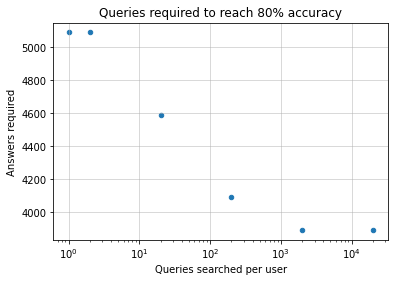

In [182]:
def ans_required(df, acc=0.75):
    valid = df[df.acc >= acc]
    return valid["num_ans"].min()

out = []
acc = 0.80
for n in show.queries_searched_per_user.unique():
    ans = ans_required(show[show.queries_searched_per_user == n], acc=acc)
    datum = {"answers": ans, "n_search": n, "acc": acc}
    out.append(datum)

plot = pd.DataFrame(out)
ax = plot.plot.scatter(x="n_search", y="answers", style="o-")
ax.set_xscale("log")
ax.grid(alpha=0.6)
ax.set_title(f"Queries required to reach {acc * 100:0.0f}% accuracy")
ax.set_xlabel("Queries searched per user")
ax.set_ylabel("Answers required")

In [180]:
plot

,answers,n_search,acc
0,3091,20000.0,0.75
1,4791,2.0,0.75
2,4891,1.0,0.75
3,4391,20.0,0.75
4,3491,2000.0,0.75
5,3591,200.0,0.75
